In [1]:
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

import copy

from utils import * 

# **The Hopfield Network**

**A Hopfield Network is a type of recurrent artificial neural network** that serves as a content-addressable memory system, meaning it can recall stored patterns from incomplete or noisy inputs. Introduced by John Hopfield in 1982 (but very similar ideas were already proposed by Kaoru Nakano in 1971 and Shun'ichi Amari in 1972), these networks are composed of a single layer of interconnected neurons, where each neuron is both an input and output, and connections between them are symmetric; for his foundational contributions to machine learning Hopfield has been awarded the 2024 Nobel Prize in Physics shared with Geoffrey Hinton.  

Hopfield networks store a set of memories $\{ X_i^{(\mu)} \}$ for $\mu \in [1, p]$ and $i \in [1, N]$, where $N$ is the number of pixels of a pattern and $p$ is the number of stored patterns.


In this notebook, **we will define a Python Class to initialize, evolve and visualise Hopfield Networks**. After writing this class, we will test some fundamental results of these networks, like the stability of its fixed points (i.e. the stored patterns). In the final part of the notebook a refined and modern version of the Hopfield Network will be introduced, that will allow us to obtain satisfying results also with more complex patterns. But first...

# A brief introduction to Python Classes 

We want to create a class called 'Hopfield Network' that initialise such a network and implements a variety of useful functions. In a nutshell, a class is a structure that holds together data and functions (called methods).

Classes can be a bit confusing at the beginning, but all you need to understand is that self means literary 'myself', that is, methods (functions) get as first argument the object they are acting on. This means that we can "store" a variable in one method and "retrieve" it in another! No need to pass it around!

Look at the following example code and play with it to make sure you understand how classes works.

In [2]:
class Model:
    # this is a special method that gets called when you create an instance of your class
    def __init__(self, name):
        self.name = name
    
    def set_x(self, x):
        self.x = x
        
    def increment_x(self):
        self.x += 1

    def show_x(self):
        return self.x

In [3]:
# Initialisation of two models
model1 = Model(name="my first model")
model2 = Model(name="another model")

In [4]:
# Using the methods implemented for the class 'Model'
model1.set_x(3)
model2.set_x(-2)

In [7]:
print(model1.show_x(),
model2.show_x())

3 -2


We can also access information stored in our objects. Notice that our models had a name that was set at initialization.

In [8]:
model1.name

'my first model'

Spend some time playing with this class by implementing new methods and trying them out.

# Exercise 6.1

Now that you have a basic understanding of Python classes, let's focus on Hopfield Networks. Start by creating 5 random patterns with shape 6x6 that the network will store and visualise them.

In [5]:
#Create 5 random patterns
N_patterns = 5
pattern_size = (6,6)
# store the pattern in a dictionary
random_patterns = {str(i): np.random.choice((-1,1),size=pattern_size) for i in range(N_patterns)}
print(random_patterns["1"])


[[-1  1  1 -1 -1 -1]
 [-1 -1 -1 -1 -1  1]
 [-1 -1 -1  1 -1  1]
 [ 1  1 -1  1  1 -1]
 [ 1  1 -1 -1 -1  1]
 [ 1 -1 -1 -1 -1 -1]]


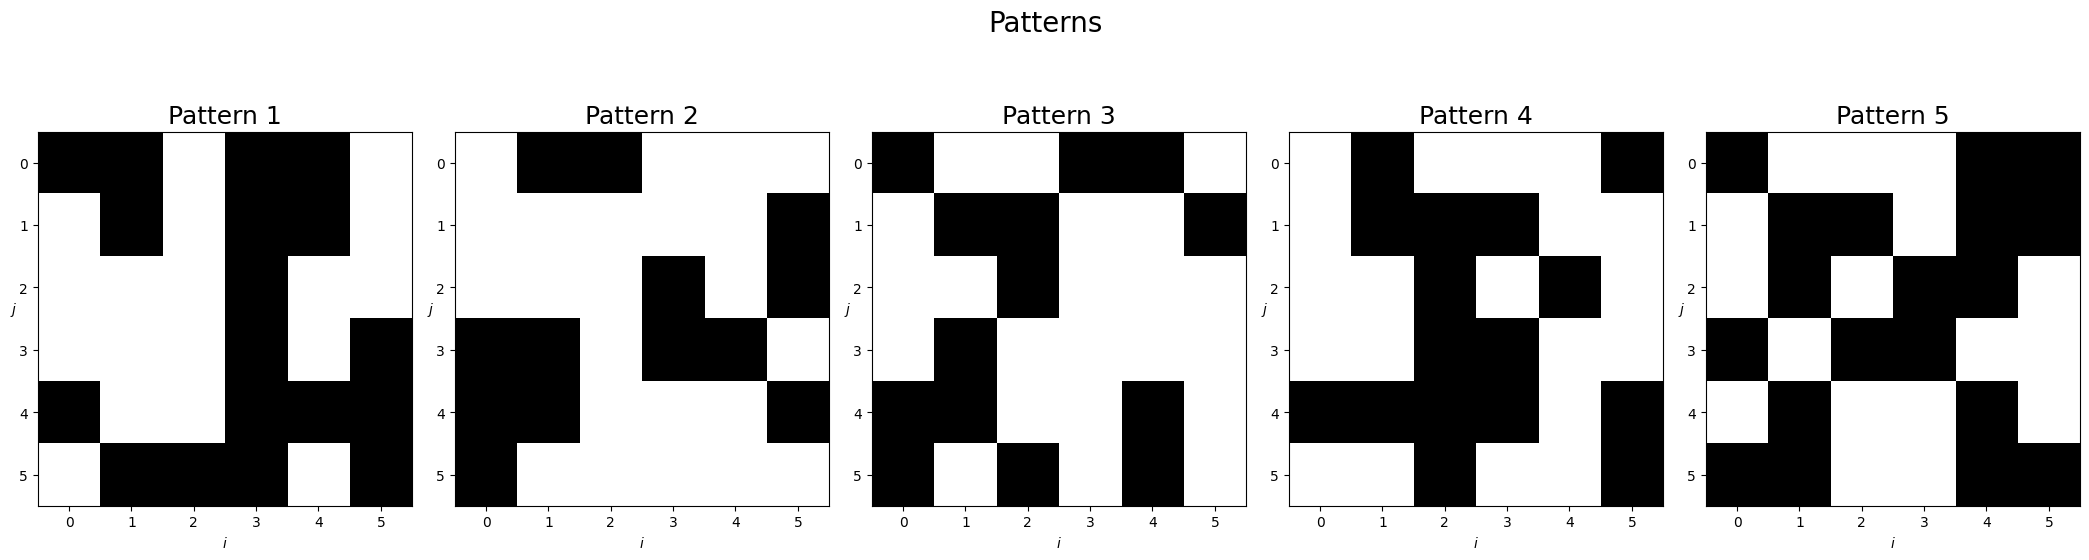

In [6]:
# visualise the patterns
fig, ax = plt.subplots(1,N_patterns, figsize=(21,6))

for i in range(N_patterns):
	ax[i].imshow(random_patterns[str(i)],cmap='Greys')
	ax[i].set_xlabel(r'$i$')
	ax[i].set_ylabel(r'$j$',rotation=0)
	ax[i].set_title(f'Pattern {i+1}',fontsize=18)

plt.suptitle(r'Patterns', fontsize=20)
plt.tight_layout()
plt.show()

Let's start to build our HopfieldNetwork class. We start by defining the constructor and implementing a few basic methods that store important information such as:

* `HFN.patterns` is a matrix containing all the patterns in their original shape 
* `HFN.N_neurons` how many neurons the network has 
* `HFN.flat_patterns` is a matrix of stored _flattened_ patterns with shape *(N_patterns, N_neurons)*.
*  ...

In [7]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """
        Initialize the Hopfield Network.
        
        Args:
            patterns_dict (dict): Dictionary where keys are pattern names and values are patterns (numpy arrays).
        """
        self.patterns_dict = patterns_dict
        self.pattern_names = list(patterns_dict.keys())
        self.patterns = np.array(list(patterns_dict.values()))
        self.pattern_shape = self.patterns[0].shape
        
        # Useful variables
        self.N_neurons = self.patterns[0].size
        self.N_patterns = len(self.pattern_names)
        
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = self.patterns.reshape(self.N_patterns, self.N_neurons)

        return

Now you can initialise you Hopfield Network! 

In [8]:
# Call the class you just defined
HFN = HopfieldNetwork(random_patterns)
HFN.flat_patterns

array([[ 1,  1, -1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1,
        -1, -1, -1, -1, -1,  1, -1,  1,  1, -1, -1,  1,  1,  1, -1,  1,
         1,  1, -1,  1],
       [-1,  1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1,  1,
        -1,  1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1,  1,  1, -1,
        -1, -1, -1, -1],
       [ 1, -1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1,  1, -1,
        -1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1,
         1, -1,  1, -1],
       [-1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1,
         1, -1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1,
         1, -1, -1,  1],
       [ 1, -1, -1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1,  1, -1,  1,
         1, -1,  1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1,
        -1, -1,  1,  1]])

## Exercise 6.2

Let's store another important element: the weights matrix. Remember that the weights matrix is defined as $J_{ij} = \frac{1}{N}\sum_{\mu=1}^px_i^{\mu}x_j^{\mu}$. 

We copy the class previously written and we add the new lines; 'self.w' must store the weights matrix, with shape N x N, where N is the number of neurons.

In [9]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """
        Initialize the Hopfield Network.
        
        Args:
            patterns_dict (dict): Dictionary where keys are pattern names and values are patterns (numpy arrays).
        """
        self.patterns_dict = patterns_dict
        self.pattern_names = list(patterns_dict.keys())
        self.patterns = np.array(list(patterns_dict.values()))
        self.pattern_shape = self.patterns[0].shape
        
        # Useful variables
        self.N_neurons = self.patterns[0].size
        self.N_patterns = len(self.pattern_names)
        
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = self.patterns.reshape(self.N_patterns, self.N_neurons)
        
        # Initialize the weight matrix using Hebbian learning
        self.w = (1. / self.N_neurons) * (self.flat_patterns.T @ self.flat_patterns)
        np.fill_diagonal(self.w, 0)  # Remove self-connections
		

In [10]:
HFN = HopfieldNetwork(random_patterns)

In [11]:
### You can access and print the stored weights
HFN.w

array([[ 0.        , -0.08333333, -0.08333333, ...,  0.02777778,
         0.08333333,  0.02777778],
       [-0.08333333,  0.        ,  0.02777778, ...,  0.02777778,
        -0.13888889,  0.02777778],
       [-0.08333333,  0.02777778,  0.        , ...,  0.02777778,
        -0.02777778, -0.08333333],
       ...,
       [ 0.02777778,  0.02777778,  0.02777778, ...,  0.        ,
        -0.02777778,  0.02777778],
       [ 0.08333333, -0.13888889, -0.02777778, ..., -0.02777778,
         0.        , -0.02777778],
       [ 0.02777778,  0.02777778, -0.08333333, ...,  0.02777778,
        -0.02777778,  0.        ]])

## Exercise 6.3
We now define two new methods: *set_state* and *update_state*. 
*set_state* sets the state of the Hopfield network. We want the method to define the state as the pattern provided to the function.
If no pattern is provided, we define the state as a random pattern.
*update_state* updates the state of the network. The update can be asynchronous (one neuron updated at a time) or synchronous (all neurons updated at once)

**Update formula**:
$$s_i(t+1)=sgn{\left(\sum_{j=1}^N J_{ij}s_j(t)+\theta_i\right)}$$

Con $i=1,...,N$ e $\theta_i=0\ \ \forall i$.

In [12]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """
        Initialize the Hopfield Network.
        
        Args:
            patterns_dict (dict): Dictionary where keys are pattern names and values are patterns (numpy arrays).
        """
        self.patterns_dict = patterns_dict
        self.pattern_names = list(patterns_dict.keys())
        self.patterns = np.array(list(patterns_dict.values()))
        self.pattern_shape = self.patterns[0].shape
        
        # Useful variables
        self.N_neurons = self.patterns[0].size
        self.N_patterns = len(self.pattern_names)
        
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = self.patterns.reshape(self.N_patterns, self.N_neurons)
        
        # Initialize the weight matrix using Hebbian learning
        self.w = (1. / self.N_neurons) * (self.flat_patterns.T @ self.flat_patterns)
        np.fill_diagonal(self.w, 0)  # Remove self-connections
        
        # Initialize the state of the network
        self.set_state(random=True)

    # =================== INITIALIZE AND UPDATE NETWORK STATE ======================
    def set_state(self, state=None, random=False):
        """
        Sets the state of the Hopfield network.
        
        Args:
            state (np.ndarray, optional): Specific state to set. Default is None.
            random (bool): If True, sets the state to a random vector.
        """
        if random:
            self.state = np.random.choice((-1, 1), size=(self.N_neurons,))
        elif state is not None:
            self.state = np.asarray(state).reshape(-1)
        else:
            raise ValueError("Either provide a state or set random=True.")

    def update_state(self, asynchronous=True):
        """
        Updates the state of the Hopfield network.
        
        Args:
            asynchronous (bool): If True, updates one neuron at a time. 
                                 If False, updates all neurons simultaneously.
        """
        if asynchronous:
            i = np.random.randint(0, self.N_neurons)
            self.state[i] = np.sign(self.w[i, :] @ self.state)
        else:
            self.state = np.sign(self.w @ self.state)

In [13]:
HFN = HopfieldNetwork(random_patterns)

## Exercise 6.4 
Implement two new methods: 'get_similarities' and 'get_energy'. You just need to complete the new methods inserted below, read the initial comment to better understand what you have to do.


**Energy**:
$$E=-\frac{1}{2}\,\bold{s\cdot J\cdot s^T}$$

In [14]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """
        Initialize the Hopfield Network.
        
        Args:
            patterns_dict (dict): Dictionary where keys are pattern names and values are patterns (numpy arrays).
        """
        self.patterns_dict = patterns_dict
        self.pattern_names = list(patterns_dict.keys())
        self.patterns = np.array(list(patterns_dict.values()))
        self.pattern_shape = self.patterns[0].shape
        
        # Useful variables
        self.N_neurons = self.patterns[0].size
        self.N_patterns = len(self.pattern_names)
        
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = self.patterns.reshape(self.N_patterns, self.N_neurons)
        
        # Initialize the weight matrix using Hebbian learning
        self.w = (1. / self.N_neurons) * (self.flat_patterns.T @ self.flat_patterns)
        np.fill_diagonal(self.w, 0)  # Remove self-connections
        
        # Initialize the state of the network
        self.set_state(random=True)

    # =================== INITIALIZE AND UPDATE NETWORK STATE ======================
    def set_state(self, state=None, random=False):
        """
        Sets the state of the Hopfield network.
        
        Args:
            state (np.ndarray, optional): Specific state to set. Default is None.
            random (bool): If True, sets the state to a random vector.
        """
        if random:
            self.state = np.random.choice((-1, 1), size=(self.N_neurons,))
        elif state is not None:
            self.state = np.asarray(state).reshape(-1)
        else:
            raise ValueError("Either provide a state or set random=True.")

    def update_state(self, asynchronous=True):
        """
        Updates the state of the Hopfield network.
        
        Args:
            asynchronous (bool): If True, updates one neuron at a time. 
                                 If False, updates all neurons simultaneously.
        """
        if asynchronous:
            i = np.random.randint(0, self.N_neurons)
            self.state[i] = np.sign(self.w[i, :] @ self.state)
        else:
            self.state = np.sign(self.w @ self.state)

    def get_similarities(self, state=None):
        """
        Computes similarity between a state and all stored patterns.
        
        Args:
            state (np.ndarray, optional): State vector. Defaults to the current state.
        
        Returns:
            np.ndarray: Array of cosine similarities.
        """
        if state is None:
            state = self.state
        state = state.reshape(-1)
        similarities = [
            np.dot(state, pattern) / (np.linalg.norm(state) * np.linalg.norm(pattern))
            for pattern in self.flat_patterns
        ]
        return np.array(similarities)

    def get_energy(self, state=None):
        """
        Computes the energy of the network at a given state.
        
        Args:
            state (np.ndarray, optional): State vector. Defaults to the current state.
        
        Returns:
            float: Energy of the state.
        """
        if state is None:
            state = self.state
        state = state.reshape(-1)
        return -0.5 * state @ self.w @ state

## Exercise 6.5
Let's define a new method 'save_history' which saves some info inside a new variable called 'history'. 
This history must be updated, so you need to implement new lines also in other methods: 'set_state'and 'update_state'.

In [15]:
class HopfieldNetwork:
    """Base class for our Hopfield Network (Modern) Hopfield Network"""

    def __init__(self, patterns_dict):
        """
        Initialize the Hopfield Network.
        
        Args:
            patterns_dict (dict): Dictionary where keys are pattern names and values are patterns (numpy arrays).
        """
        self.patterns_dict = patterns_dict
        self.pattern_names = list(patterns_dict.keys())
        self.patterns = np.array(list(patterns_dict.values()))
        self.pattern_shape = self.patterns[0].shape
        
        # Useful variables
        self.N_neurons = self.patterns[0].size
        self.N_patterns = len(self.pattern_names)
        
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = self.patterns.reshape(self.N_patterns, self.N_neurons)
        
        # Initialize the weight matrix using Hebbian learning
        self.w = (1. / self.N_neurons) * (self.flat_patterns.T @ self.flat_patterns)
        np.fill_diagonal(self.w, 0)  # Remove self-connections
        
        # Initialize history
        self.history = {"state": [], "similarities": [], "energy": []}
        
        # Initialize the state of the network
        self.set_state(random=True)

    # =================== INITIALIZE AND UPDATE NETWORK STATE ======================
    def set_state(self, state=None, random=False):
        """
        Sets the state of the Hopfield network.
        
        Args:
            state (np.ndarray, optional): Specific state to set. Default is None.
            random (bool): If True, sets the state to a random vector.
        """
        if random:
            self.state = np.random.choice((-1, 1), size=(self.N_neurons,))
        elif state is not None:
            self.state = np.asarray(state).reshape(-1)
        else:
            raise ValueError("Either provide a state or set random=True.")
        
        self.save_history()

    def update_state(self, asynchronous=True):
        """
        Updates the state of the Hopfield network.
        
        Args:
            asynchronous (bool): If True, updates one neuron at a time. 
                                 If False, updates all neurons simultaneously.
        """
        if asynchronous:
            i = np.random.randint(0, self.N_neurons)
            self.state[i] = np.sign(self.w[i, :] @ self.state)
        else:
            self.state = np.sign(self.w @ self.state)
        
        self.save_history()

    # =================== ANALYSIS AND HISTORY FUNCTIONS ======================
    def save_history(self):
        """Saves the current state, similarities, and energy to the network's history."""
        self.history["state"].append(self.state.copy())
        self.history["similarities"].append(self.get_similarities(self.state))
        self.history["energy"].append(self.get_energy(self.state))

    def get_similarities(self, state=None):
        """
        Computes similarity between a state and all stored patterns.
        
        Args:
            state (np.ndarray, optional): State vector. Defaults to the current state.
        
        Returns:
            np.ndarray: Array of cosine similarities.
        """
        if state is None:
            state = self.state
        state = state.reshape(-1)
        similarities = [
            np.dot(state, pattern) / (np.linalg.norm(state) * np.linalg.norm(pattern))
            for pattern in self.flat_patterns
        ]
        return np.array(similarities)

    def get_energy(self, state=None):
        """
        Computes the energy of the network at a given state.
        
        Args:
            state (np.ndarray, optional): State vector. Defaults to the current state.
        
        Returns:
            float: Energy of the state.
        """
        if state is None:
            state = self.state
        state = state.reshape(-1)
        return -0.5 * state @ self.w @ state

## Exercise 6.6
We are almost done creating our class! Let's add just a few methods to visualise the results. In the file 'utils.py' you'll find three functions already implemented, so you do not need to write the code yourself. You can import those functions and use them to define three new methods for your class. 

In [16]:
#### IMPORT THE FUCTIONS DEFINED IN 'utils.py' ####

from utils import * 

In [17]:
import numpy as np

class HopfieldNetwork:
    """Base class for a Hopfield Network (Modern Hopfield Network)."""

    def __init__(self, patterns_dict):
        """
        Initialize the Hopfield Network.
        
        Args:
            patterns_dict (dict): Dictionary where keys are pattern names and values are patterns (numpy arrays).
        """
        self.patterns_dict = patterns_dict
        self.pattern_names = list(patterns_dict.keys())
        self.patterns = np.array(list(patterns_dict.values()))
        self.pattern_shape = self.patterns[0].shape
        
        # Useful variables
        self.N_neurons = self.patterns[0].size
        self.N_patterns = len(self.pattern_names)
        
        # Flatten the patterns into a matrix of shape (N_patterns, N_neurons)
        self.flat_patterns = self.patterns.reshape(self.N_patterns, self.N_neurons)
        
        # Initialize the weight matrix using Hebbian learning
        self.w = (1. / self.N_neurons) * (self.flat_patterns.T @ self.flat_patterns)
        np.fill_diagonal(self.w, 0)  # Remove self-connections
        
        # Initialize history
        self.history = {"state": [], "similarities": [], "energy": []}
        
        # Initialize the state of the network
        self.set_state(random=True)

    # =================== INITIALIZE AND UPDATE NETWORK STATE ======================
    def set_state(self, state=None, random=False):
        """
        Sets the state of the Hopfield network.
        
        Args:
            state (np.ndarray, optional): Specific state to set. Default is None.
            random (bool): If True, sets the state to a random vector.
        """
        if random:
            self.state = np.random.choice((-1, 1), size=(self.N_neurons,))
        elif state is not None:
            self.state = np.asarray(state).reshape(-1)
        else:
            raise ValueError("Either provide a state or set random=True.")
        
        self.save_history()

    def update_state(self, asynchronous=True):
        """
        Updates the state of the Hopfield network.
        
        Args:
            asynchronous (bool): If True, updates one neuron at a time. 
                                 If False, updates all neurons simultaneously.
        """
        if asynchronous:
            i = np.random.randint(0, self.N_neurons)
            self.state[i] = np.sign(self.w[i, :] @ self.state)
        else:
            self.state = np.sign(self.w @ self.state)
        
        self.save_history()

    # =================== ANALYSIS AND HISTORY FUNCTIONS ======================
    def save_history(self):
        """Saves the current state, similarities, and energy to the network's history."""
        self.history["state"].append(self.state.copy())
        self.history["similarities"].append(self.get_similarities(self.state))
        self.history["energy"].append(self.get_energy(self.state))
        
	# ================== ADDING MEMORY LOSS =======================
    def clear_memory(self):
        self.history = {"state": [], "similarities": [], "energy": []}

    def get_similarities(self, state=None):
        """
        Computes similarity between a state and all stored patterns.
        
        Args:
            state (np.ndarray, optional): State vector. Defaults to the current state.
        
        Returns:
            np.ndarray: Array of cosine similarities.
        """
        if state is None:
            state = self.state
        state = state.reshape(-1)
        similarities = [
            np.dot(state, pattern) / (np.linalg.norm(state) * np.linalg.norm(pattern))
            for pattern in self.flat_patterns
        ]
        return np.array(similarities)

    def get_energy(self, state=None):
        """
        Computes the energy of the network at a given state.
        
        Args:
            state (np.ndarray, optional): State vector. Defaults to the current state.
        
        Returns:
            float: Energy of the state.
        """
        if state is None:
            state = self.state
        state = state.reshape(-1)
        return -0.5 * state @ self.w @ state

    # =================== PLOTTING FUNCTIONS ==============================
    def visualise(self, steps_back=0, fig=None, ax=None, title=None):
        """Visualises the state of the Hopfield network n_steps back (defaults to steps_back=0, i.e. current state)"""
        fig, ax = visualise_hopfield_network(self,steps_back=steps_back,title=title)
        return fig, ax

    def plot_energy(self, n_steps=None):
        """Plots the energy of the Hopfield network over time. n_steps=None defaults to _all_ steps"""
        fig, ax = plot_energy(self,n_steps=n_steps)
        return fig, ax

    def animate(self, n_steps=10, fps=10, animation_length_secs=5):
        """Animates the last n_steps of the Hopfield network. fps gives frames per socond of resulting animation"""
        anim = animate_hopfield_network(self,n_steps=n_steps,fps=fps,animation_length_secs=animation_length_secs)
        return anim

n_steps: None
n_steps: 50


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

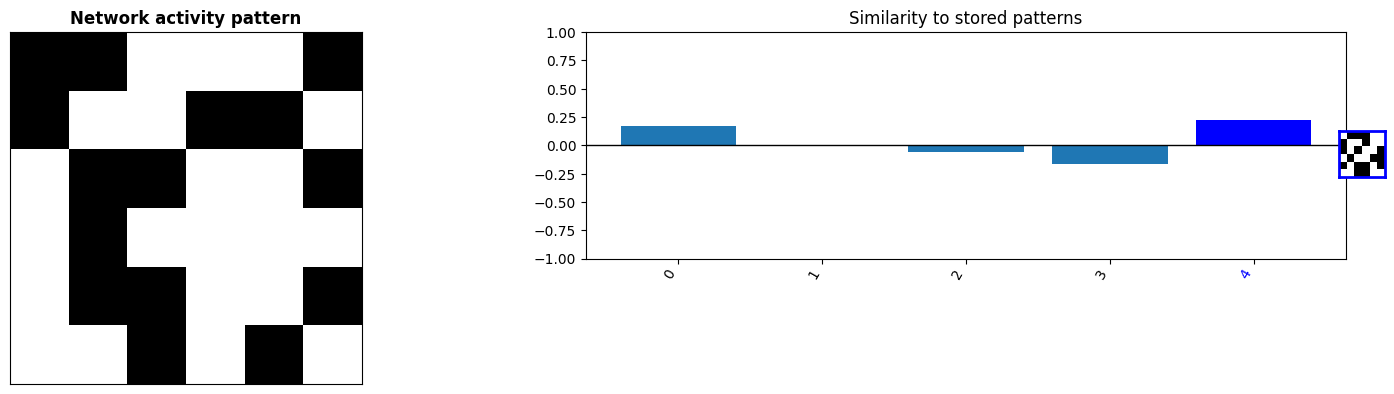

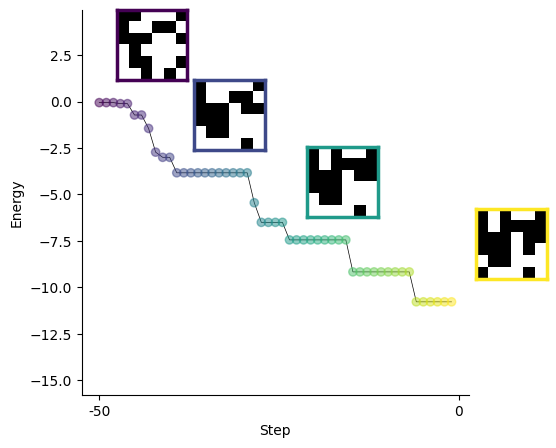

In [18]:
HFN_fin = HopfieldNetwork(random_patterns)
HFN_fin.visualise()
for i in range(51):
	HFN_fin.update_state()
HFN_fin.plot_energy()

# FIXED POINTS

## Exercise 6.7

In class we proved that the stored patterns are fixed points of the dynamics, meaning that the system will evolve towards one of the stored patterns starting from any configuration. In particular, if the system is initialised as one of the stored states, it will stay in that configuration. Check if this is true by visualising the starting state and the state after several updates (apply several times the *update_state* method that you defined). You can also check that the energy of the system is constant. Use the *visualise* and *plot_energy* methods that you defined in your class.

n_steps: None
n_steps: 51


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

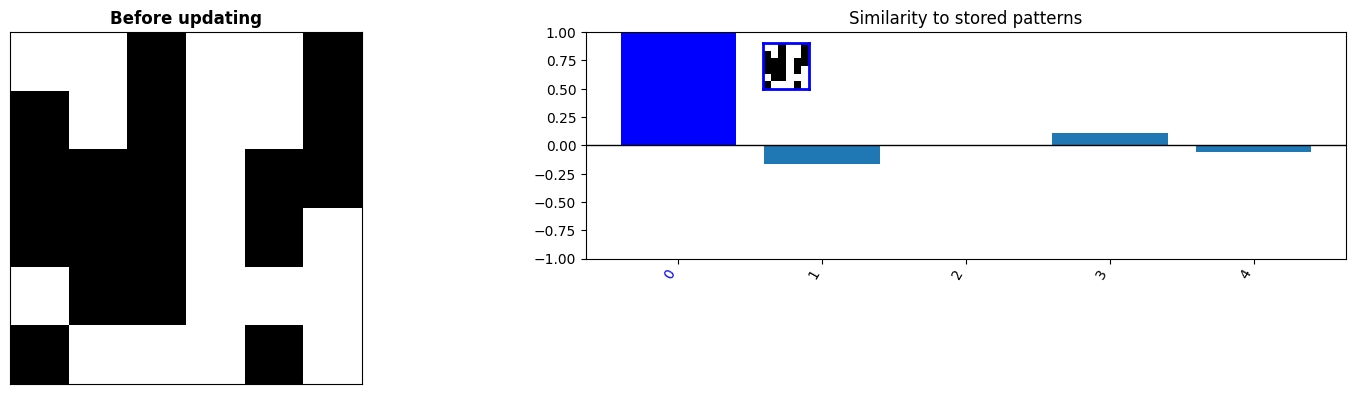

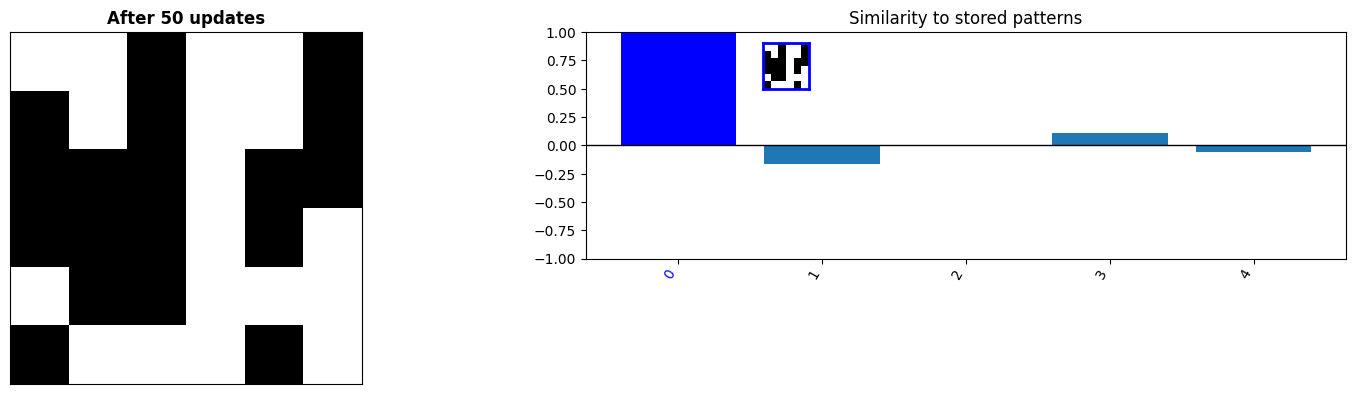

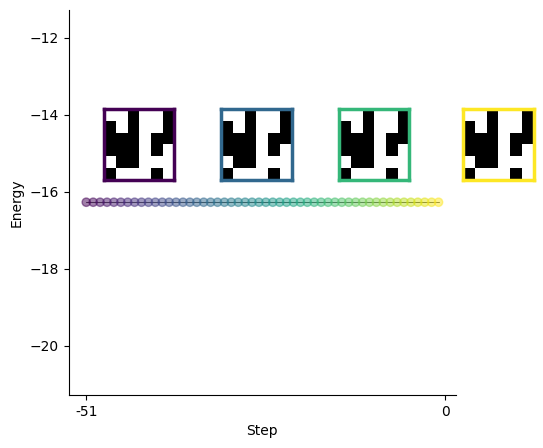

In [19]:
HFN_fin = HopfieldNetwork(random_patterns)
pattern = HFN_fin.patterns[0]
HFN_fin.set_state(pattern,False)
HFN_fin.visualise(title='Before updating')
for i in range(51):
    HFN_fin.update_state()
HFN_fin.visualise(title='After 50 updates')
HFN_fin.plot_energy()

### YOUR CODE HERE

## Exercise 6.8

Do the same but starting from a random configuration. Check that the system evolves towards one of the stored patterns and that the energy decreases until a minimum is reached.

n_steps: None
n_steps: 51


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

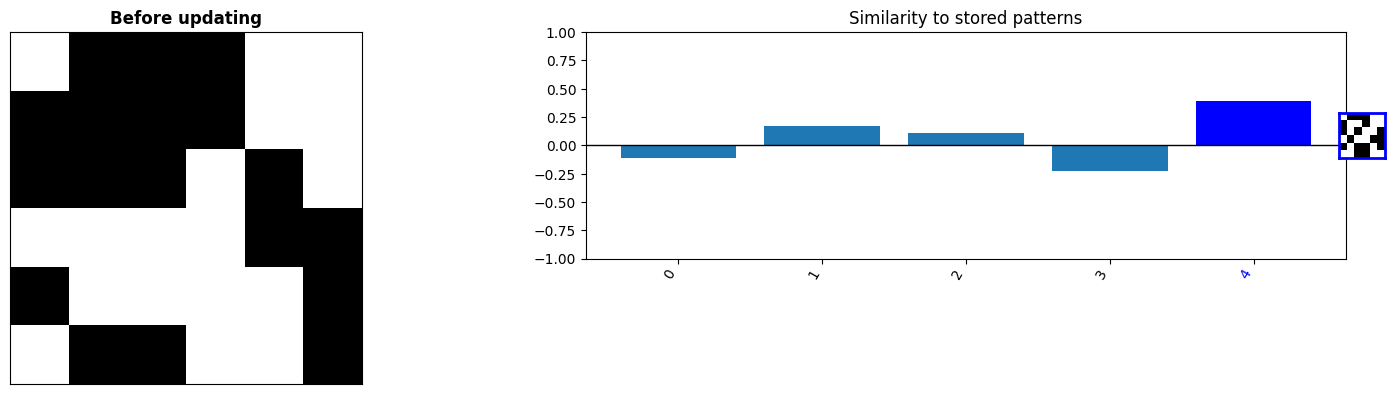

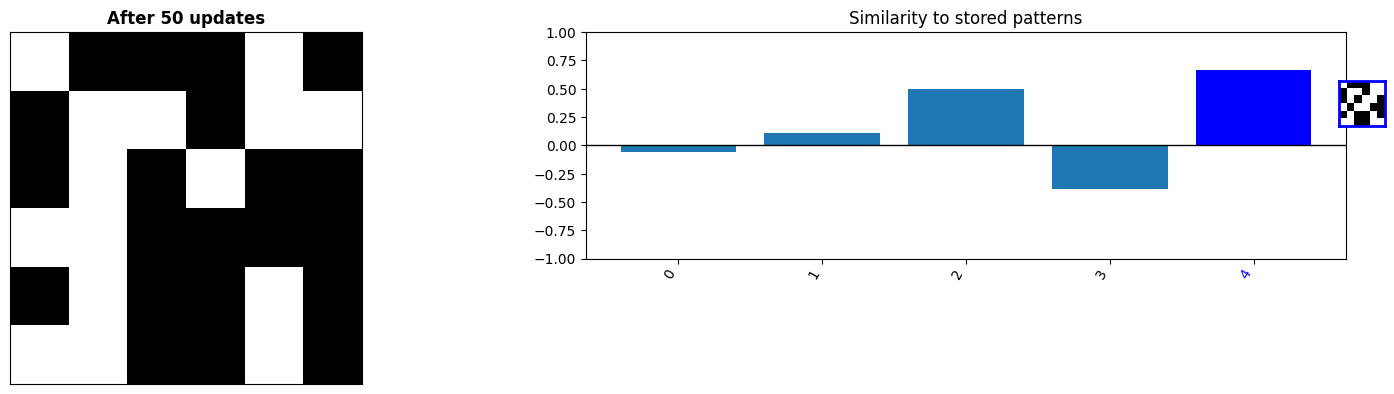

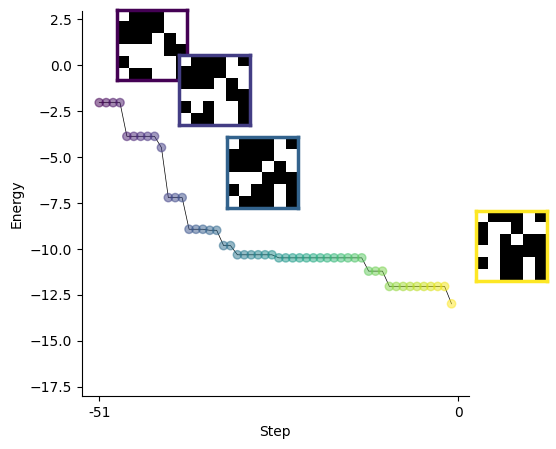

In [20]:
HFN_fin = HopfieldNetwork(random_patterns)
HFN_fin.set_state(random=True)
HFN_fin.visualise(title='Before updating')
for i in range(51):
    HFN_fin.update_state()
HFN_fin.visualise(title='After 50 updates')
HFN_fin.plot_energy()

### YOUR CODE HERE 

# IMAGE RECOGNITION

## Exercise 6.9

One of the applications of the Hopfield Network is image recognition. By starting from a pattern which is 'similar' to one of the stored ones, the system should evolve towards that state; it is essentially 'recognising' the picture. Try to add some 'noise' to one of the stored patterns and then use this noisy pattern as the starting state. Check that the network correctly evolves towards the right pattern. At what level of noise the network starts to fail? 

n_steps: None
n_steps: 50


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

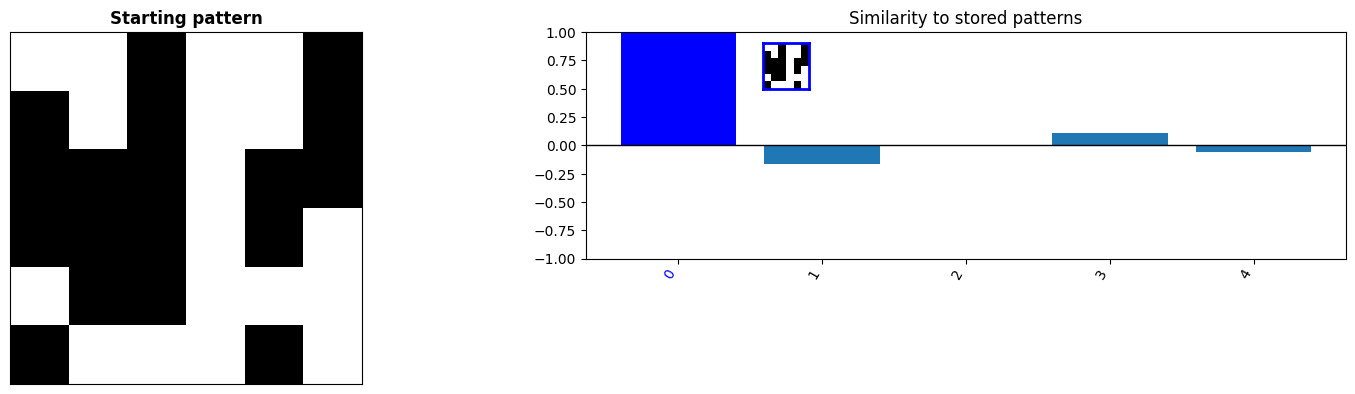

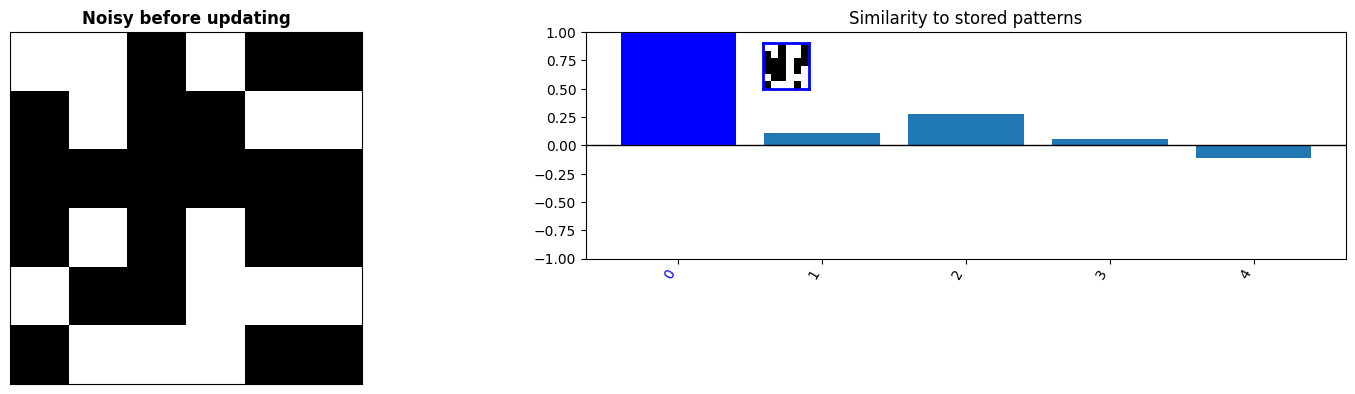

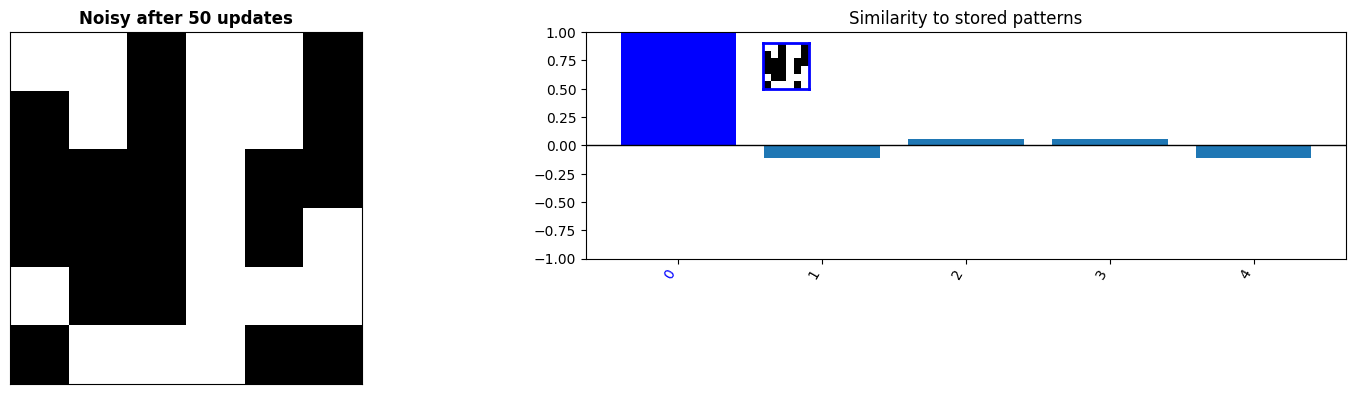

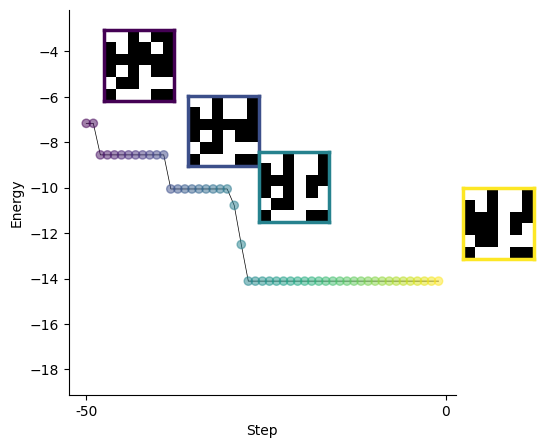

In [21]:
HFN= HopfieldNetwork(random_patterns)
pattern_to_start = HFN.patterns[0]
X = 20 # percentage of bits to flip 

HFN.set_state(pattern_to_start,False)
HFN.visualise(title='Starting pattern')
HFN.clear_memory()

#add some noise to the starting pattern
indices = np.random.choice(pattern_to_start.size, size=int(pattern_to_start.size*0.2), replace=False)

noisy_state = pattern_to_start.ravel()
noisy_state[indices] *= -1
noisy_state = noisy_state.reshape((6, 6))

HFN.set_state(noisy_state,False)
HFN.visualise(title='Noisy before updating')
for i in range(51):
    HFN.update_state()
HFN.visualise(title='Noisy after 50 updates')
HFN.plot_energy()

#reinitialise the state of the network, evolve it for several steps and then visualise 

### YOUR CODE HERE

## Exercise 6.10

Can the Hopfield Network recognise an image if only a small part of it is provided? For instance, is it able to recognise an image if we provide only the upper left corner? To check, you first need to write a function that masks the given pattern. Complete the function below and then use it to check if the network can recognise one of the stored patterns using only one corner.

In [22]:
def apply_mask(pattern):
    """Masks 75% of the pattern, by setting to zero all the elements of the pattern except the top-left corner"""
    mask = np.zeros_like(pattern)
    mask[:3, :3] = 1  # Mantieni il quadrante in alto a sinistra (3x3)
    ### YOUR CODE HERE
    return pattern * mask

n_steps: None
n_steps: 50


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

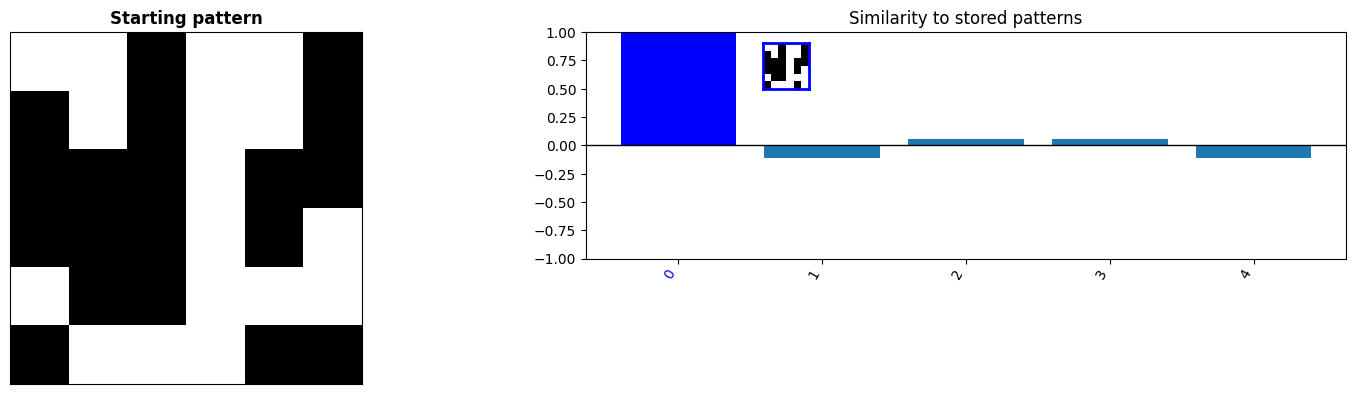

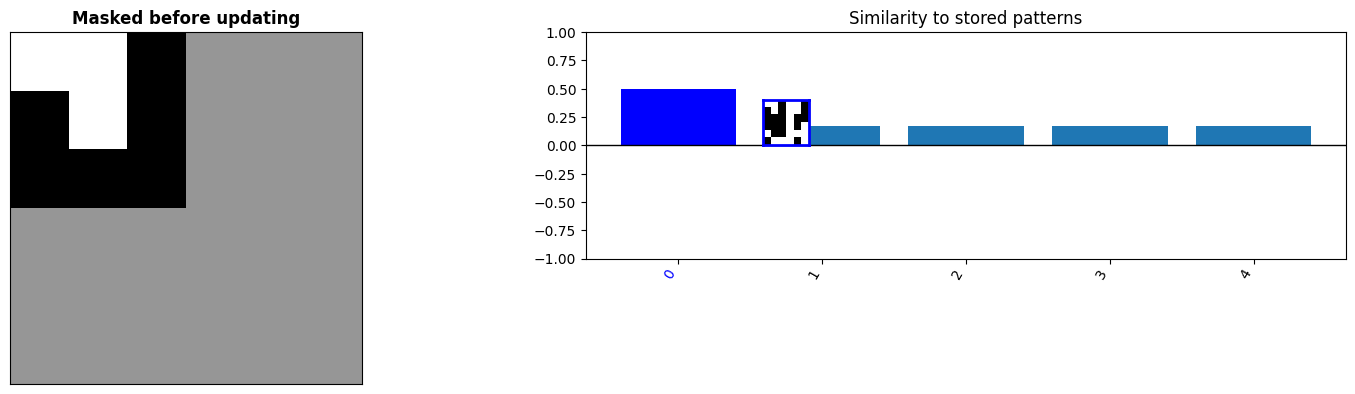

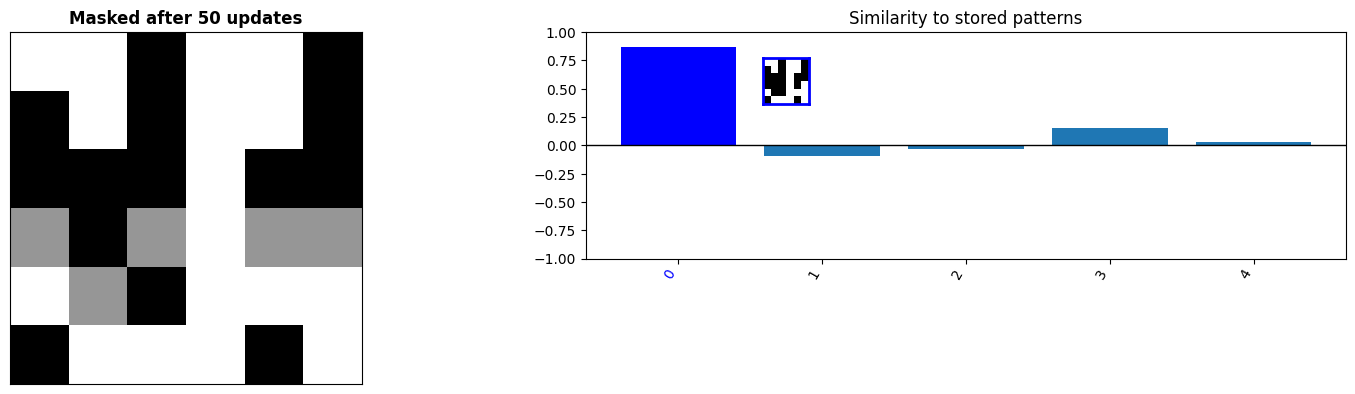

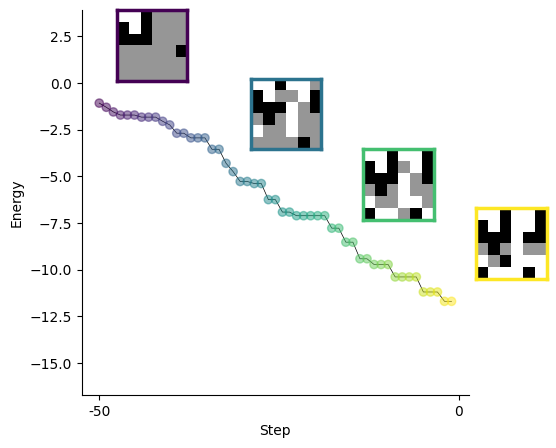

In [23]:
pattern_to_start = HFN.patterns[0]  
partially_masked_pattern = apply_mask(pattern_to_start)
HFN.set_state(pattern_to_start,False)
HFN.visualise(title='Starting pattern')
HFN.clear_memory()
HFN.set_state(partially_masked_pattern,False)
#reinitialise the state of the network, evolve it for several steps and then visualise 
HFN.visualise(title='Masked before updating')
for i in range(51):
    HFN.update_state()
HFN.visualise(title='Masked after 50 updates')
HFN.plot_energy()
### YOUR CODE HERE

## Exercise 6.11 
The stored patterns are not the only fixed points of our dynamics. Prove analytically that also the negatives of the stored patterns (defined by $-x_i^{\mu}$) are fixed points of the dynamics. Then, check numerically the validity of this claim by starting from the negative of a stored pattern and evolving the system.

$$s_i(t+1)=sgn\left(\sum_{j=1}^NJ_{ij}(-s_j(t))\right)=-sgn\left(\sum_{j=1}^NJ_{ij}s_j(t)\right)\hspace{2em}s_i(t\to\infty)\to -x_i^1$$

n_steps: None
n_steps: 50


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

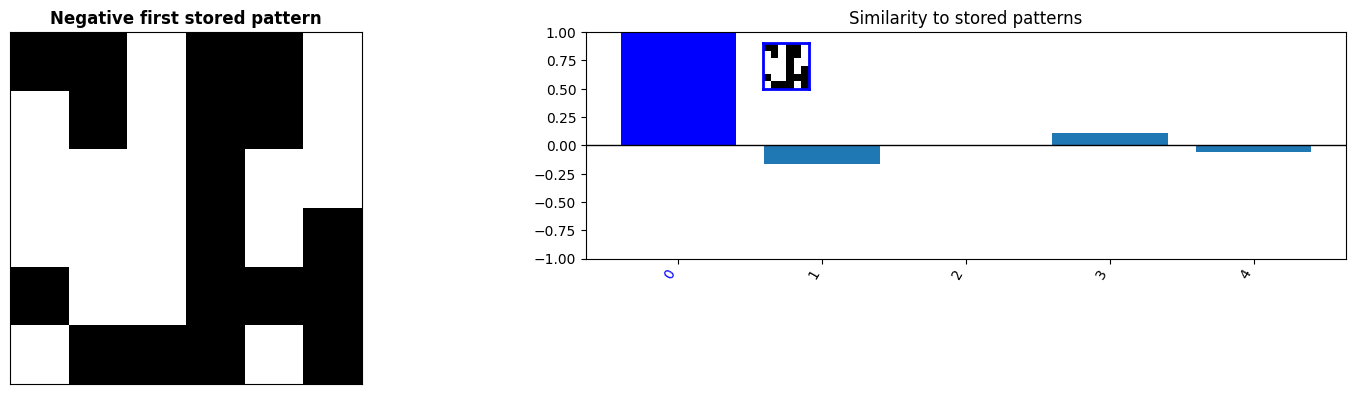

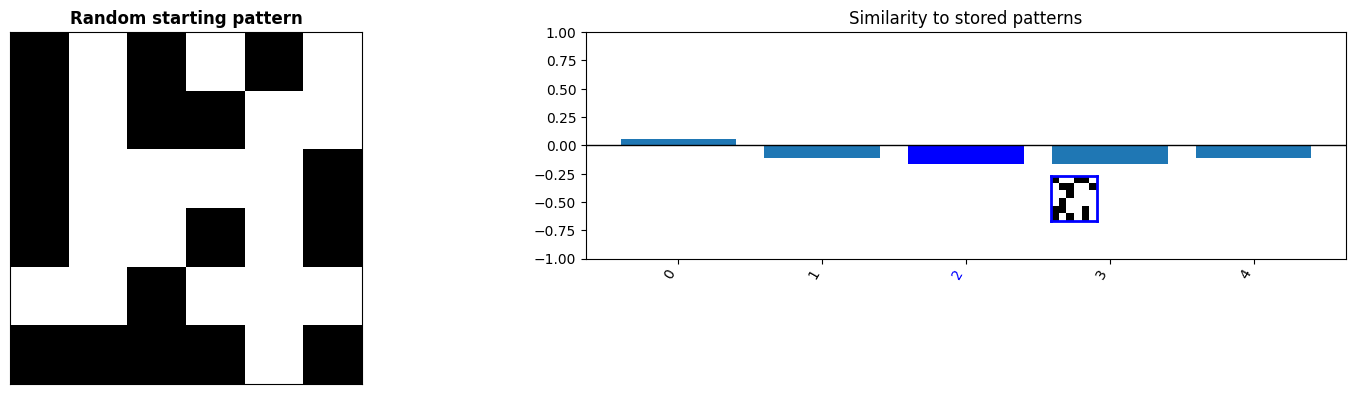

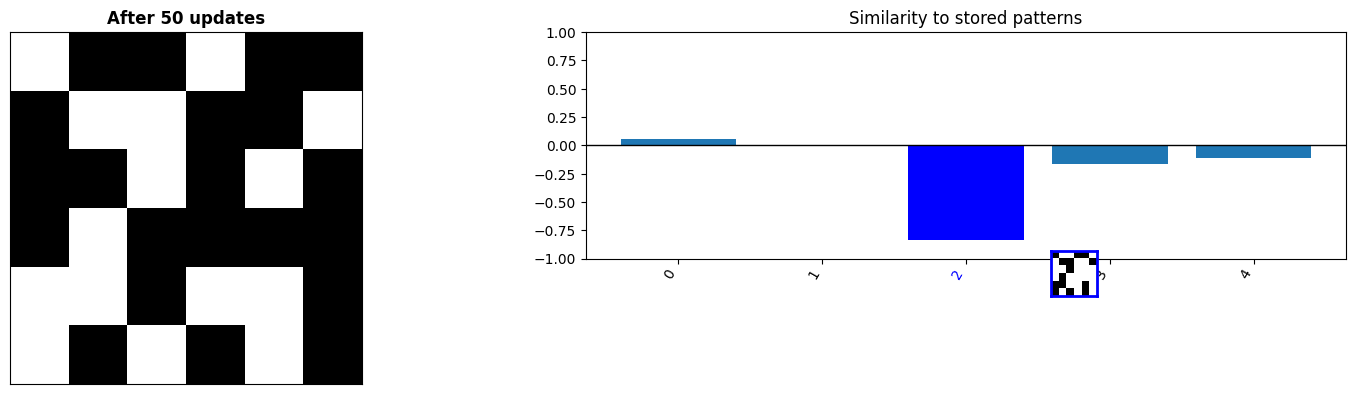

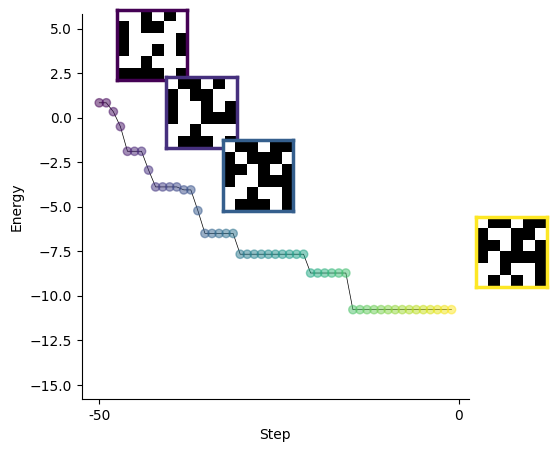

In [24]:
HFN = HopfieldNetwork(random_patterns)
pattern = HFN.patterns_dict

negative_pattern = {key: -1*pattern[key] for key in pattern.keys()}

HFN = HopfieldNetwork(negative_pattern)
HFN.set_state(HFN.patterns[0])
HFN.visualise(title='Negative first stored pattern')
HFN.clear_memory()

HFN.set_state(random=True)
HFN.visualise(title='Random starting pattern')
for i in range(51):
    HFN.update_state()
HFN.visualise(title='After 50 updates')
HFN.plot_energy()

#reinitialise the state of the network, evolve it for several steps and then visualise 


n_steps: None
n_steps: 50


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

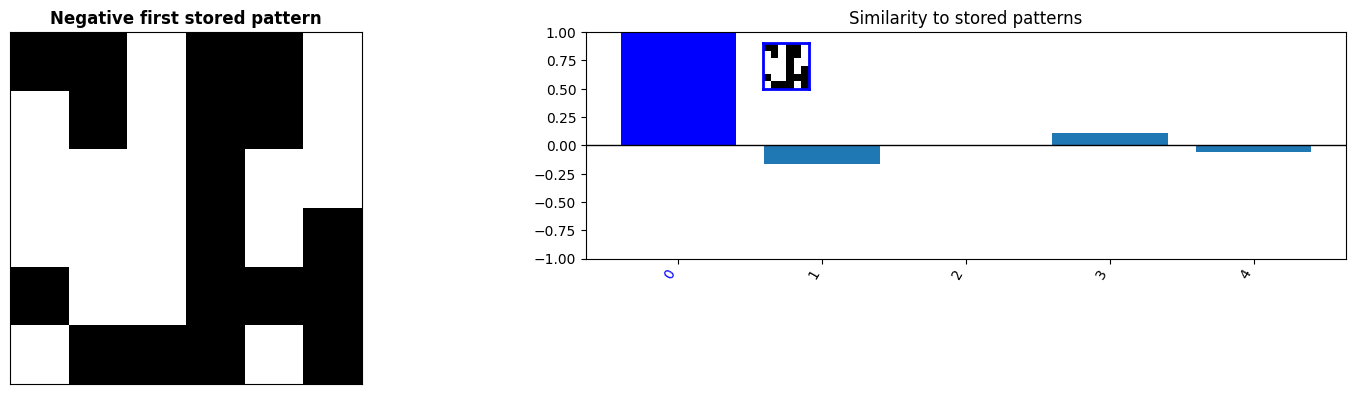

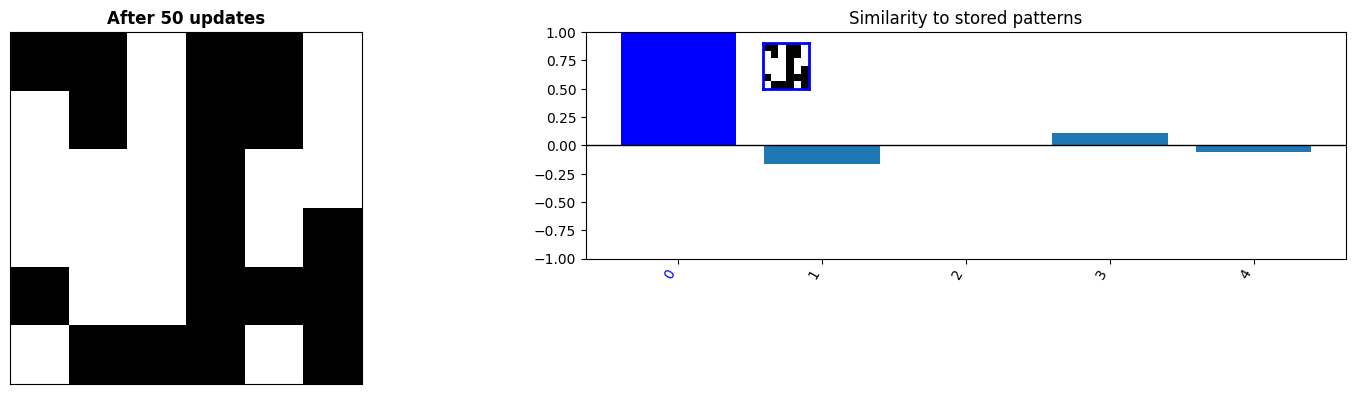

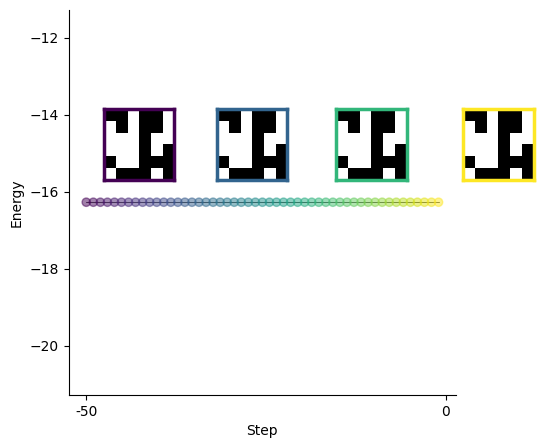

In [25]:
HFN.clear_memory()
HFN.set_state(HFN.patterns[0])
HFN.visualise(title='Negative first stored pattern')
for i in range(51):
    HFN.update_state()
HFN.visualise(title='After 50 updates')
HFN.plot_energy()

# Exercise 6.12 

What happens if we try to initialise the network in a mixed state? For example and mix of patterns 1, 2 and 3: 

$$ s_i(0) := x_i^{\textrm{mix}} = \textrm{sgn} \big( \pm x_i^{(1)} \pm x_i^{(2)} \pm x_i^{(3)} \big)$$


n_steps: None
n_steps: 51


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

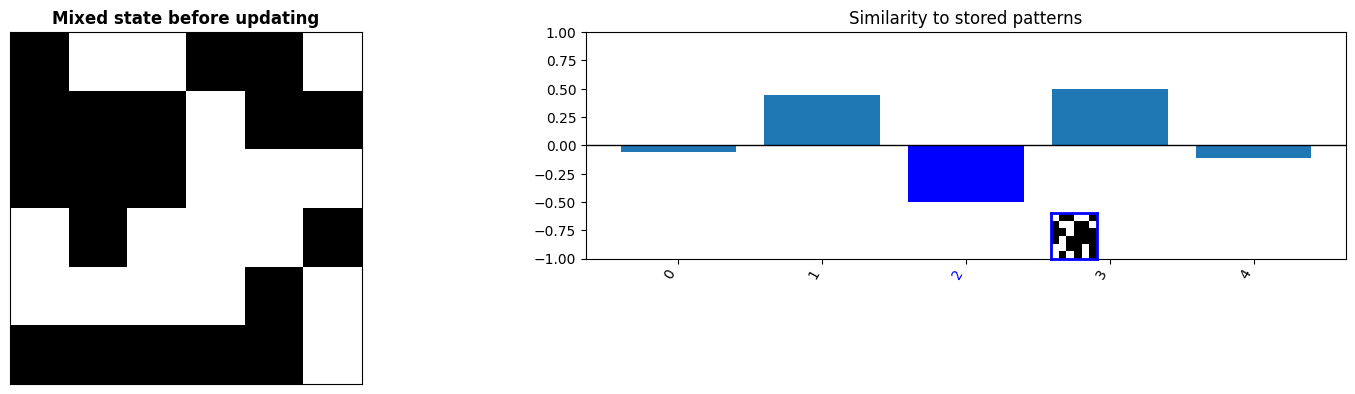

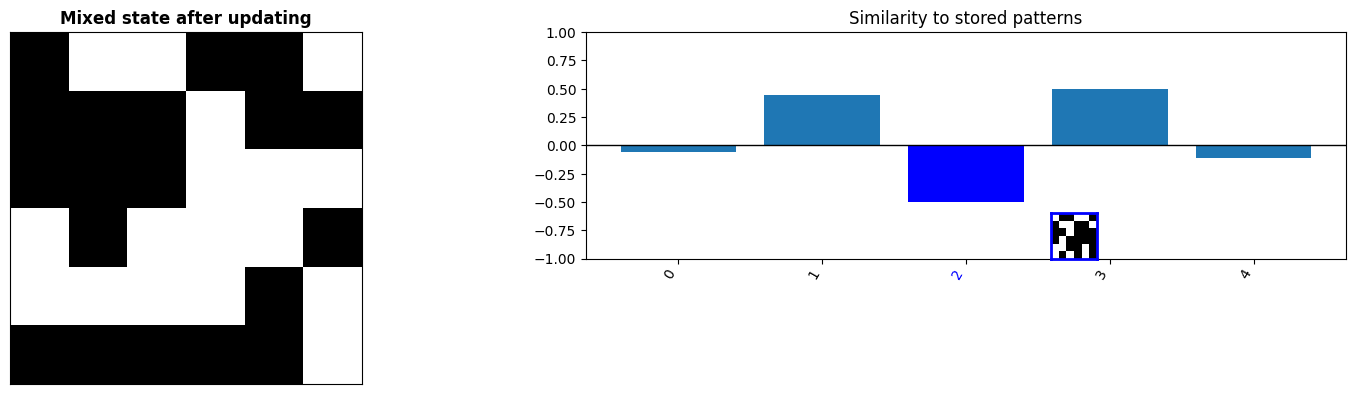

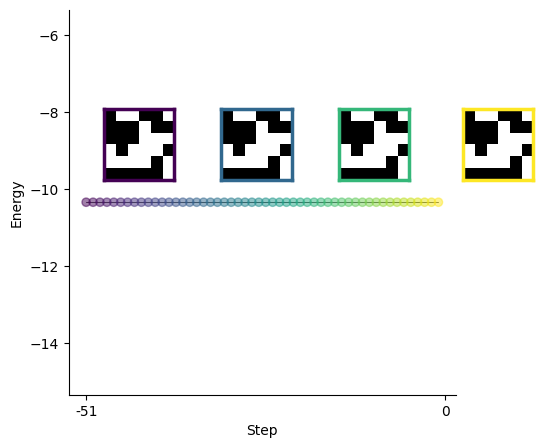

In [26]:
##### define a mixed state
HFN = HopfieldNetwork(random_patterns)
mixed_state = np.sign(random_patterns['1'].flatten() - random_patterns['2'].flatten() + random_patterns['3'].flatten())
mixed_state.reshape((6,6))
HFN.set_state(mixed_state,False)
HFN.visualise(title='Mixed state before updating')
for i in range(51):
    HFN.update_state()
HFN.visualise(title='Mixed state after updating')
HFN.plot_energy()
#reinitialise the state of the network, evolve it for several steps and then visualise 

### YOUR CODE HERE

# Exercise 6.13

The Hopfield Network has a storage capacity, meaning that if the number of stored patterns is too high for the number of neurons, it will show issues in correctly retrieving the patterns. 

The storage capacity for a classical Hopfield Network can be estimated as $C\approx\frac{N}{2\log_2 N}$.

Test a Hopfield network with a number of stored patterns way higher than its capacity (for instance try to store 20 patterns with 4x4 pixels) and show that it fails in retrieving these patterns.

n_steps: None
n_steps: 51


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

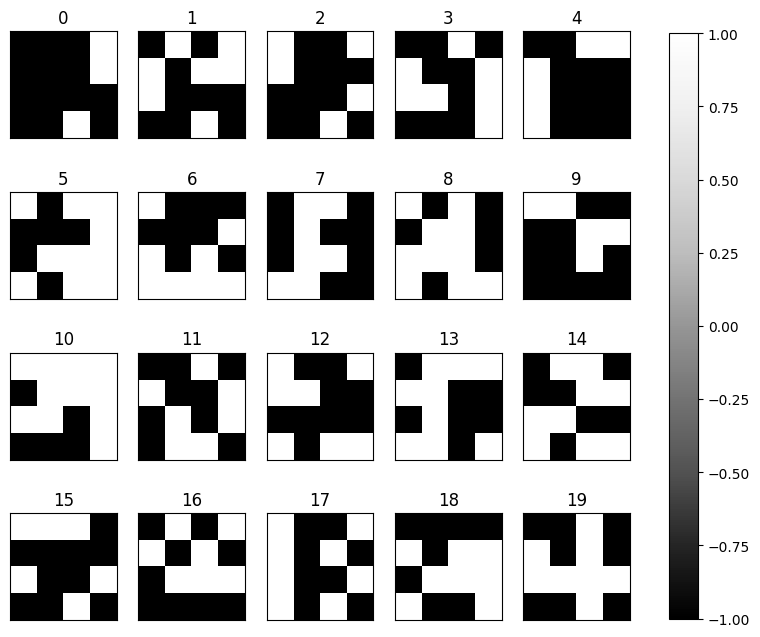

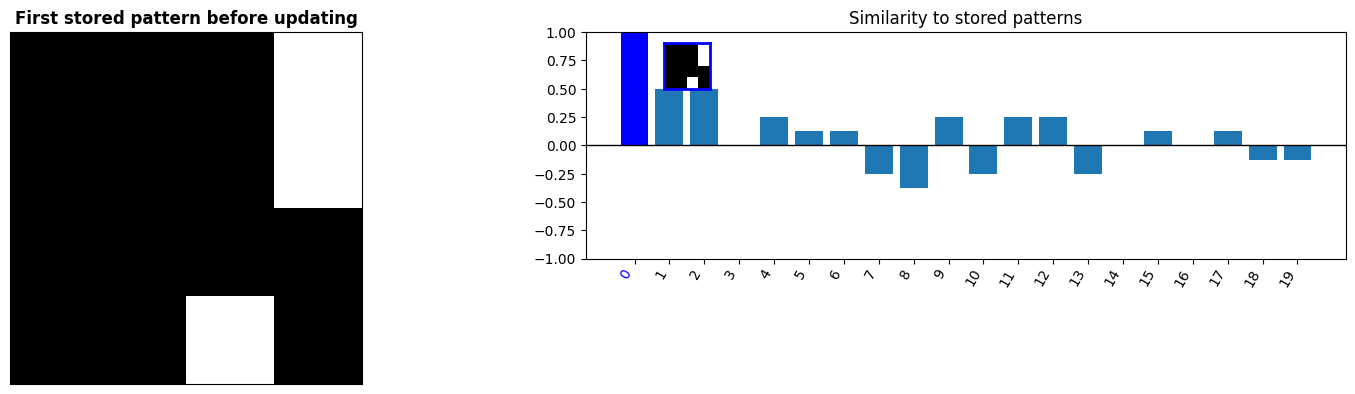

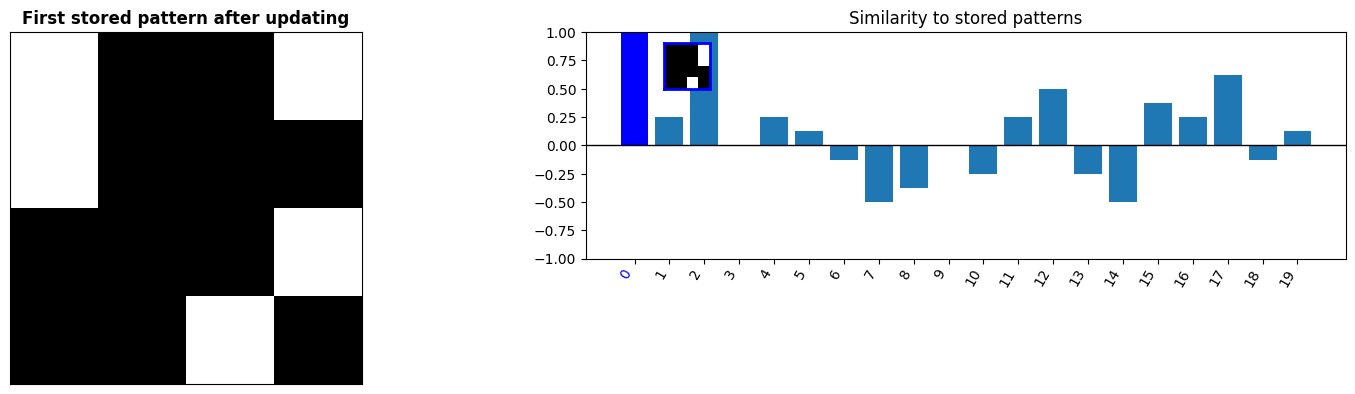

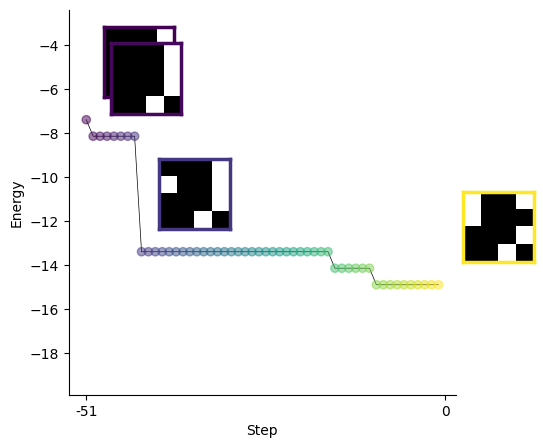

In [27]:
#Create 20 random patterns of size 4x4
N_patterns = 20
pattern_size = (4,4)
random_patterns_20 = {str(i): np.random.choice((-1,1),size=pattern_size) for i in range(N_patterns)}

fig, ax = plot_patterns(random_patterns_20)

HFN = HopfieldNetwork(random_patterns_20)
HFN.set_state(HFN.patterns[0])
HFN.visualise(title='First stored pattern before updating')
for i in range(51):
    HFN.update_state()
HFN.visualise(title='First stored pattern after updating')
HFN.plot_energy()

Not all the patterns are equally 'unstable', some of them will still act as fixed points, while other will not. Try different starting patterns among those stored and try to find a pattern which is 'stable' and one that is 'unstable'. 

1-th stored pattern is stable
n_steps: None
n_steps: 50
3-th stored pattern is stable
n_steps: None
n_steps: 50


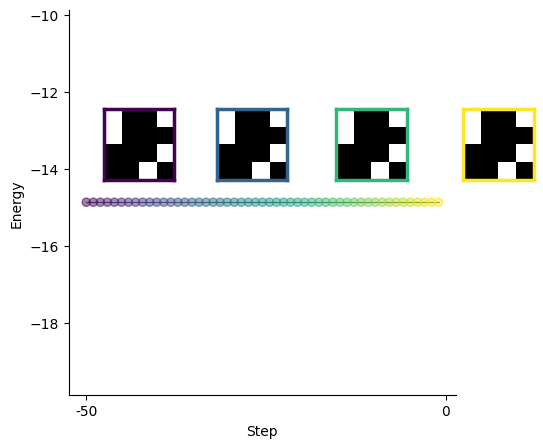

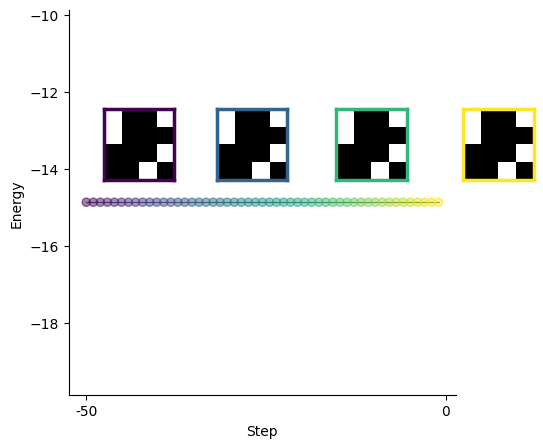

In [28]:
# Try to start from all the stored patterns and find the stable or unstable ones.
HFN.clear_memory()
for j in range(N_patterns):
    HFN.set_state(HFN.patterns[j],False)
    for i in range(51):
        HFN.update_state()
    if HFN.history['energy'][-1]==HFN.history['energy'][0]:
        print(f'{j+1}-th stored pattern is stable')
        HFN.plot_energy()
    HFN.clear_memory()


# The Classical Hopfield Networks fails with complex patterns


The network that we implemented is very good at recognising simple patterns, as long as you do not exceed the capacity of you network. But it will fail with more complex patterns.

In the next cell, we will load **more complex patterns**, namely a few sprites from the Pokemon videogames. These images are way bigger than the patterns previously used (120x112 pixels).

To convert the images from the *.png* format to matrices, we'll need a package called *openCV*. If not already installed on your system, you can easily install it by running

    pip install opencv-python

in your terminal.

In [184]:
import cv2
import os

directory = os.fsencode("pokemon")

patterns = {}
      
for file in os.listdir(directory):
    filename = os.fsdecode(file)

    patterns[filename[:-4]] = (cv2.imread("pokemon/" + filename, cv2.IMREAD_GRAYSCALE)/255)*2 - 1


In [185]:
# Initialise a new Hopfield network with the new patterns
for key in patterns.keys():
    for i in range(patterns[key].shape[0]):
        for j in range(patterns[key].shape[1]):
            if patterns[key][i,j]==-1:
                patterns[key][i,j]=0
HFN = HopfieldNetwork(patterns)

n_steps: 5


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

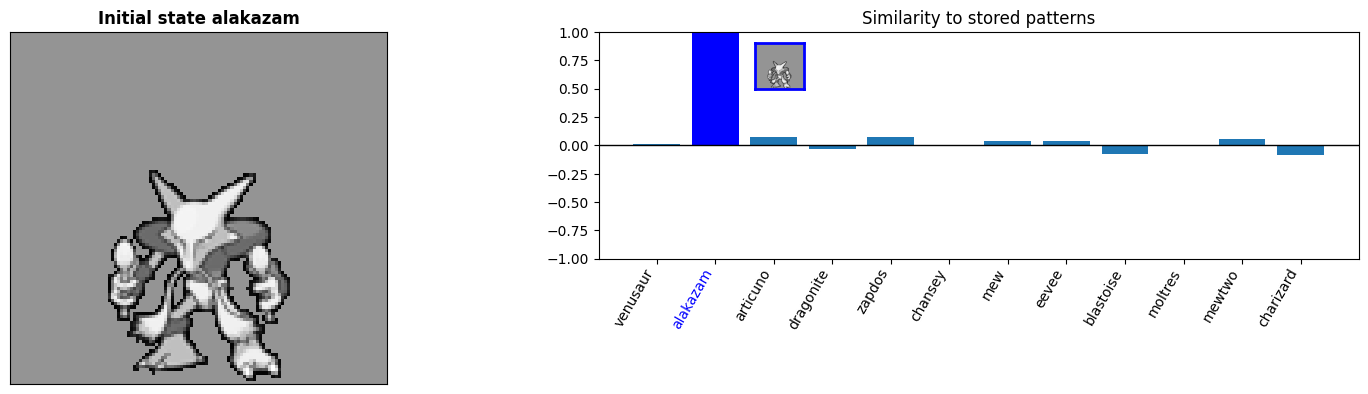

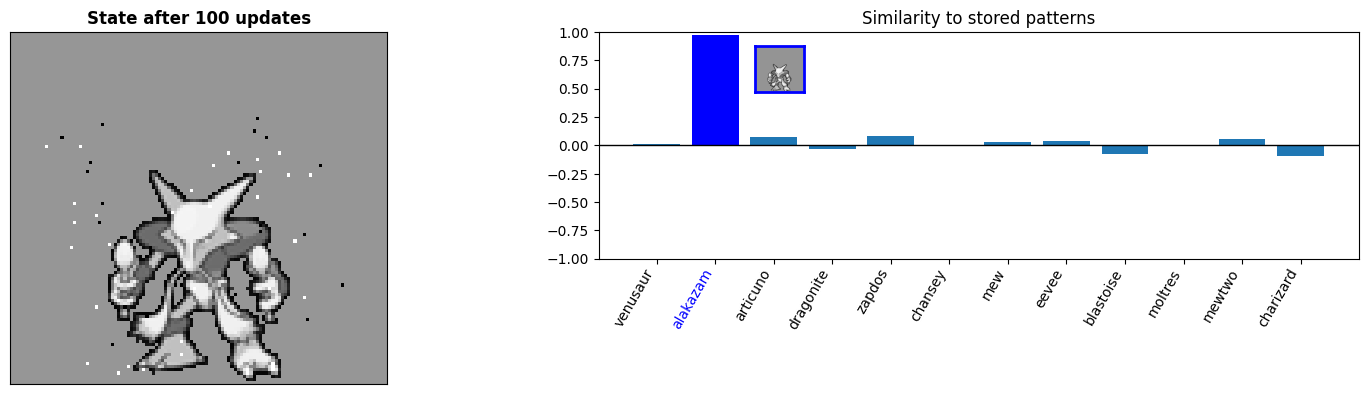

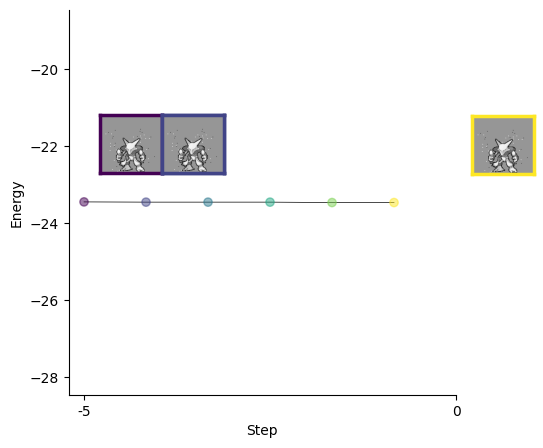

In [186]:
pokemon = 'alakazam'

HFN.set_state(patterns[pokemon].flatten()) #reinitialise the state of the network
HFN.visualise(title=f"Initial state {pokemon}")
for i in range(100):
    HFN.update_state(asynchronous=True)
HFN.visualise(title=f"State after {i+1} updates")

HFN.plot_energy(n_steps = 5)

You'll soon realize that **our Hopfield Network is not doing great with these more complex patterns**. There are probably two main reasons: the patterns are not binary (they are grayscale images, not black and white) and also they are **too correlated** , with a white/gray silhouette in the central-bottom part of the square surrounded by a large portion of black pixels.
It's time for an upgrade...

# Let's upgrade: Modern Hopfield Networks

The performances of the Hopfield Network can be greatly improved by just modifying the energy function and the update rule. 
The new rules are:

| | **Classic** | **Modern** |
| ----------- | ----------- | ----------- |
| **Update rule** | $ \vec{s} \leftarrow \textrm{sign}\big(\underbrace{\vec{x}\vec{x}^{\mathsf{T}}}_{\mathsf{J}}\vec{s}\big)$ | $\vec{s} \leftarrow \vec{x} \textrm{softmax}(\beta \vec{x}^{\mathsf{T}}\vec{s})$ |
| **Energy function** | $ E(\vec{s}) = \vec{s}^{\mathsf{T}}\underbrace{\vec{x}\vec{x}^{\mathsf{T}}}_{\mathsf{J}}\vec{s}$ | $E(\vec{s}) = -\textrm{lse}\big(\vec{x}^{\mathsf{T}}\vec{s}\big) + \frac{1}{2} \vec{s}^{\mathsf{T}}\vec{s}$ |

where the softmax function is defined as $\text{softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^{K}e^{x_j}}$ and the log-sum-exp function is $\text{lse}(\mathbf{x})=\log(\sum_{i=0}^{K}e^{x_i})$.

# Exercise 6.14 

Implement the *softmax* and *lse* functions, then complete the new class *ModernHopfieldNetwork* by defining the new energy function and update rule.

Finally, test your new model on the complex patterns and show that, starting from a random pattern, the system correctly converge to one of the Pokemon sprites.

In [87]:
def softmax(x, beta):
    exp_x = np.exp(beta * (x - np.max(x)))  # Numerical stability
    return exp_x / np.sum(exp_x)

def log_sum_exp(x,beta=0.01):
    max_x = np.max(x)
    return max_x + np.log(np.sum(np.exp(beta*(x - max_x))))

We want the new class to inherit all the methods from our original `HopfieldNetwork` class so we can use all the same plotting functions. Complete the *update_state* and *get_energy* methods.

In [187]:
class ModernHopfieldNetwork(HopfieldNetwork):

    def __init__(self, patterns_dict, beta=0.01):
        self.beta = beta
        super().__init__(patterns_dict)
        
    def set_state(self,state=None,random=True):
        """
        Sets the state of the Hopfield network.
        
        Args:
            state (np.ndarray, optional): Specific state to set. Default is None.
            random (bool): If True, sets the state to a random vector.
        """
        if random:
            self.state = np.random.uniform(low=-1, high=1, size=self.pattern_shape)
        elif state is not None:
            self.state = np.asarray(state).reshape(-1)
        else:
            raise ValueError("Either provide a state or set random=True.")
        
        self.save_history()

    def update_state(self):
        """
        Updates the state of the Modern Hopfield network using a continuous update rule with softmax dynamics.
        """
        state = self.state.reshape(-1)
        self.state = self.flat_patterns.T @ softmax(self.flat_patterns @ state.T, self.beta)
        self.save_history()

    def get_energy(self, state=None):
        """
        Computes the energy of the Modern Hopfield network at a given state.

        Args:
            state (np.ndarray, optional): State vector. Defaults to the current state.

        Returns:
            float: Energy of the state.
        """
        if state is None:
            state = self.state
        state = state.reshape(-1)
        return -log_sum_exp(self.flat_patterns @ state.T) + 0.5 * np.dot(state, state)

**Time to test the new network!** Initialise a Modern Hopfield Network using the complex patterns we imported. Then start from a random pattern and check if the system evolves towards one of the stored patterns. You can also plot the energy.

n_steps: None
n_steps: 50


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

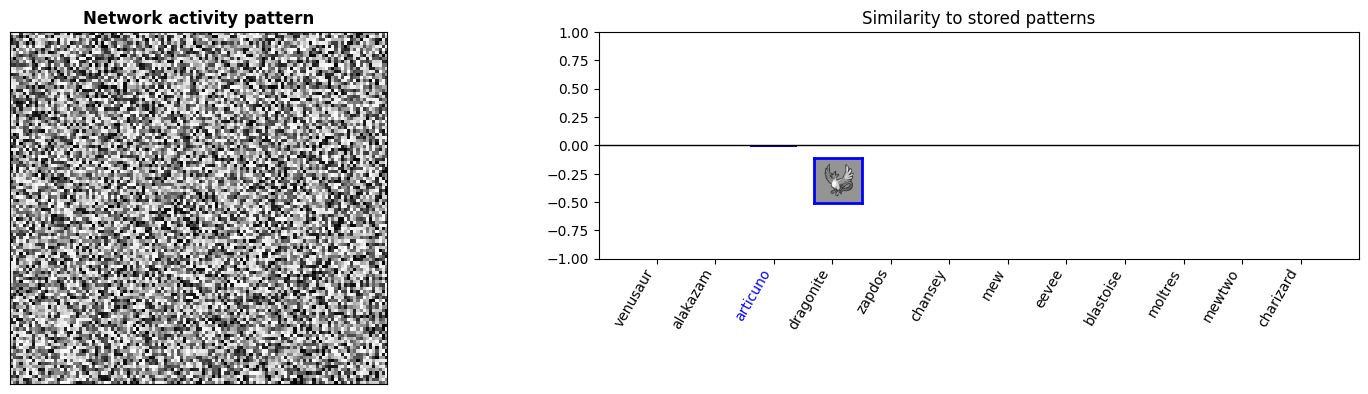

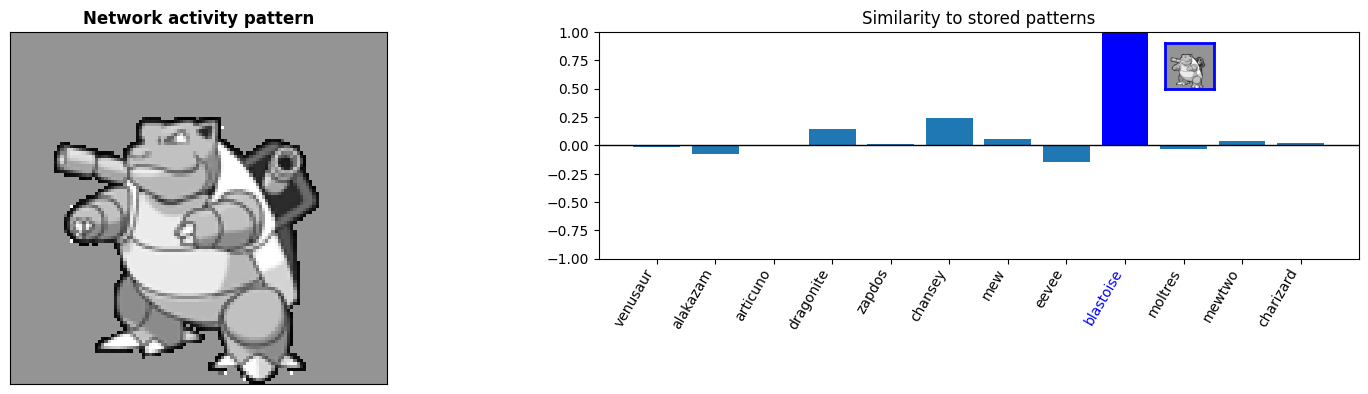

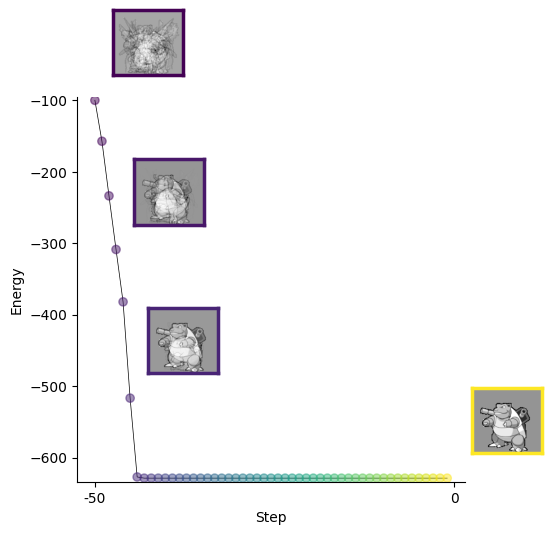

In [194]:
MHFN = ModernHopfieldNetwork(HFN.patterns_dict)

#reinitialise the state of the network, evolve it for several steps and then visualise 

MHFN.visualise()
for i in range(51):
	MHFN.update_state()
MHFN.visualise()
MHFN.plot_energy()

# Exercise 6.15

Like you did previously with simple patterns, show that our new Hopfield Network is able to recognize images even when they are noisy or when a large portion of the image is hidden/masked.


n_steps: None
n_steps: 20


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

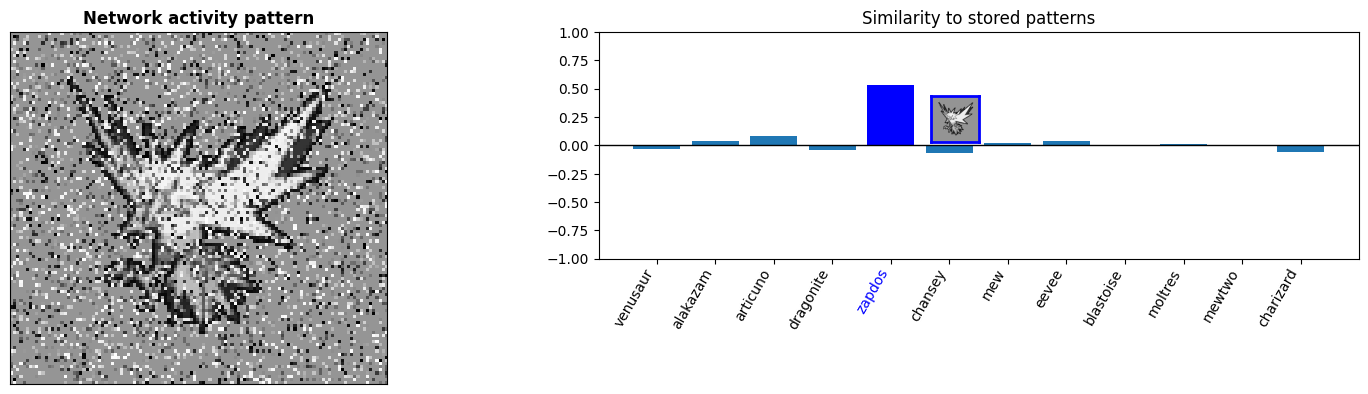

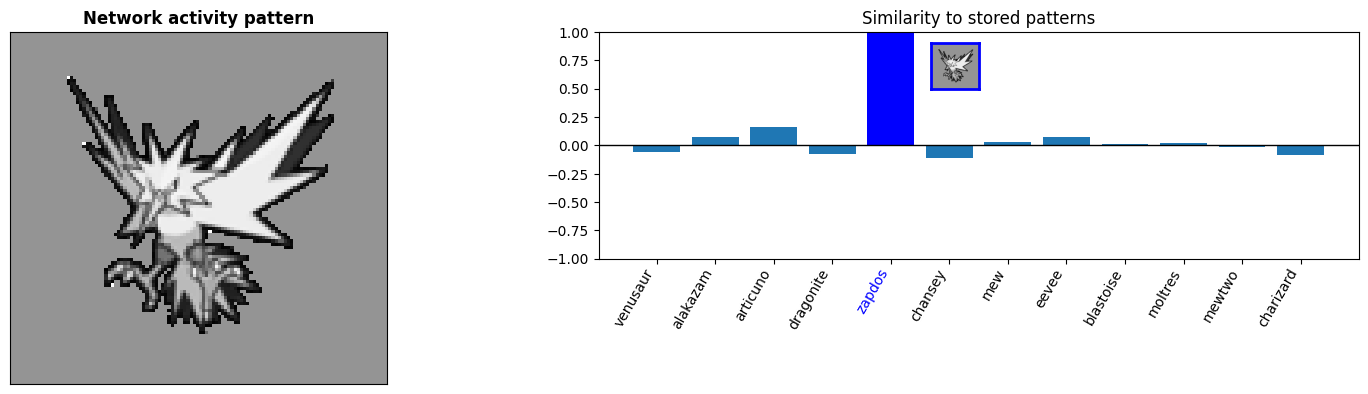

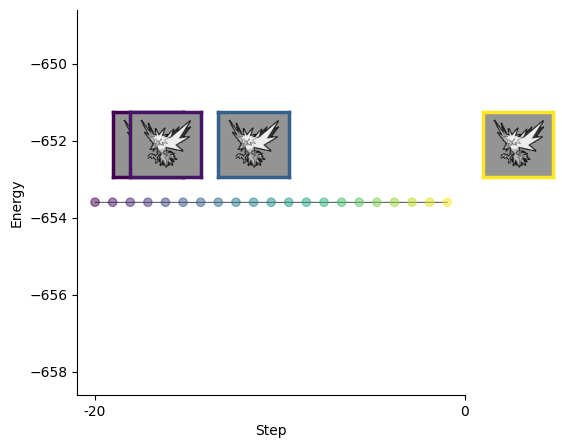

In [192]:
### START WITH THE NOISY PATTERN...

MHFN.clear_memory()

pattern_to_start = MHFN.patterns[4].copy()

X = 30  
total_elements = pattern_to_start.size
num_to_modify = int(total_elements * X / 100)

indices_to_modify = np.random.choice(total_elements, size=num_to_modify, replace=False)
new_values = np.random.uniform(low=-1, high=1, size=num_to_modify)

noisy_flat = pattern_to_start.ravel()  
noisy_flat[indices_to_modify] = new_values
noisy_state = noisy_flat.reshape(pattern_to_start.shape)

MHFN.set_state(noisy_state, random=False)
MHFN.visualise()
for i in range(21):
    MHFN.update_state()
MHFN.visualise()
MHFN.plot_energy()

#reinitialise the state of the network, evolve it for several steps and then visualise 

n_steps: None
n_steps: 20


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

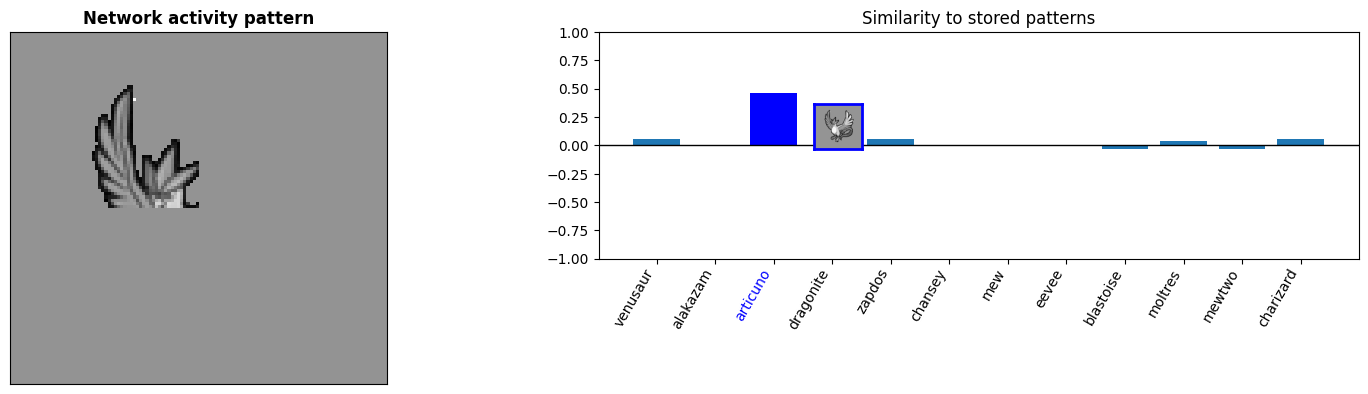

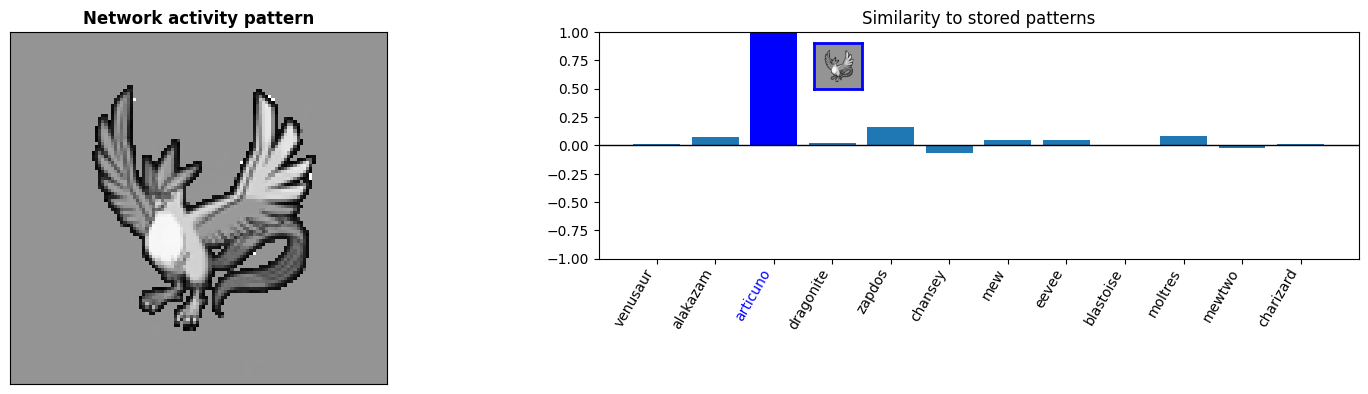

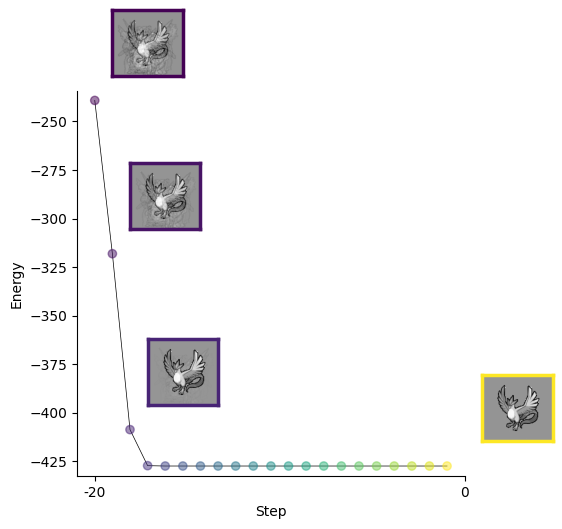

In [191]:
### ... NOW DO THE SAME WITH THE MASKED PATTERN

MHFN.clear_memory()

pattern_to_start = MHFN.patterns[2].copy()

masked_flag = mask_pattern(pattern_to_start)

MHFN.set_state(masked_flag, random=False)
MHFN.visualise()
for i in range(21):
    MHFN.update_state()
MHFN.visualise()
MHFN.plot_energy()

#reinitialise the state of the network, evolve it for several steps and then visualise 


# Exercise 6.16

In the update function for the Modern Hopfield Network we use a scalar quantity called $\beta$, a sort of inverse temperature.

Try to evolve a random state with the Modern Hopfield Network using a very high temperature, for instance $\beta \leftarrow 0.001$. What do you see?

If everything you did is correct, you should see that at high temperature the network evolves towards metastable states. Can you briefly explain why you see this behaviour?



Ad alta temperatura l'energia calcolata con **LSE** tende a diminuire, il che comporta un maggiore peso ai punti fissi distanti dal pattern di partenza. La probabilità di convergenza ad un punto fisso casuale aumenta e di conseguenza si ha una sovrapposizione di immagini.

n_steps: None
n_steps: 50


(<Figure size 500x500 with 1 Axes>, <Axes: xlabel='Step', ylabel='Energy'>)

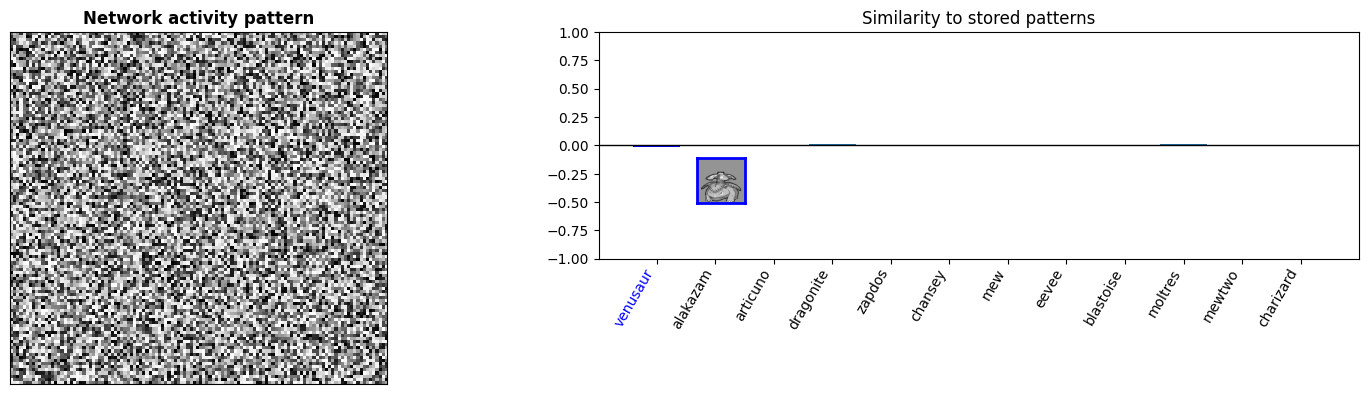

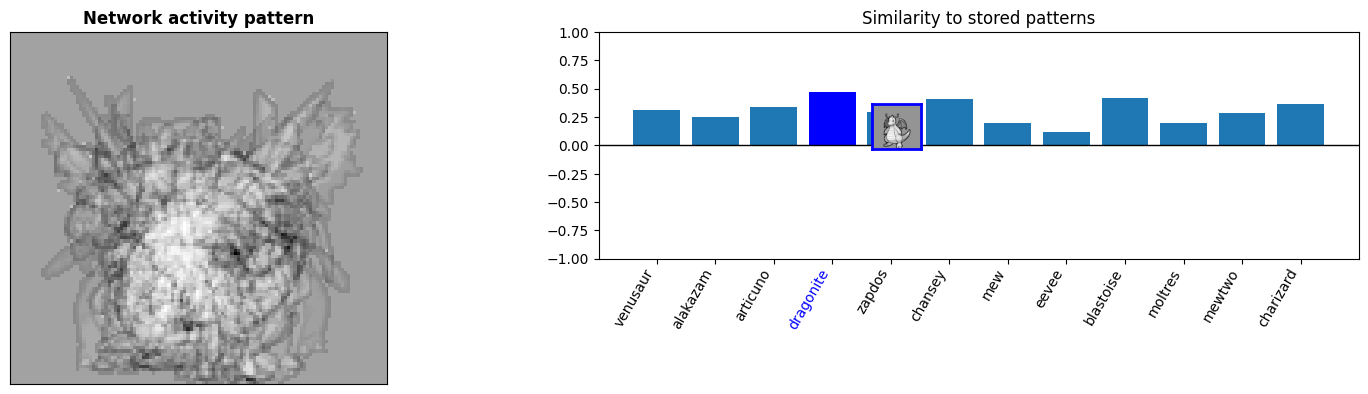

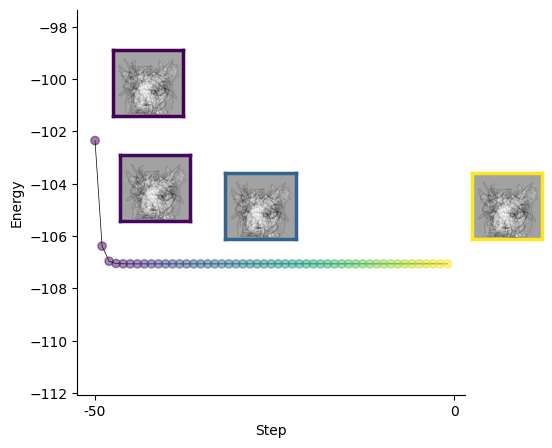

In [197]:
MHFN = ModernHopfieldNetwork(HFN.patterns_dict,beta=0.001)

#reinitialise the state of the network, evolve it for several steps and then visualise 

MHFN.visualise()
for i in range(51):
	MHFN.update_state()
MHFN.visualise()
MHFN.plot_energy()